### Neighborhood Reconstruction Methods (chapter 3 of book)

#### Encoder-Decoder

- The goal is to learn (graph) node embeddings, which encode the nodes as low-dimensional vectors, capturing the nodes graph position and their neighborhood structure.
- Nodes are projected into a latent/hidden space, where geometric relationships between the embeddings correspond to the relationships in the original graph.
- Node embedding can be approached with the _encoding-decoding_ framework.
- This is an example of "graph representation learning": the act of learning a representation of the graph.
- Two operations in this learning process are the _encoder_ (mapping nodes to vectors), and the _decoder_, which reconstruct information about the original nodes based on the vector embeddings (this is vague, but will be made precise).
- Example of shallow embedding as encoder: $ENC: V \to \mathbb{R}^d$. Notation: $ENC(v) = z_v$. 
    - The encoder is a lookup function: $ENC(v) = Z[v]$, where $Z \in \mathbb{R}^{|V|\times d}$, a matrix with all the embeddings as rows, and $Z[v]$ denoting the row corresponding to $v \in V$.
    - More general encoders use information about the graph, beyond the node id, for example node features or local graph structure.
- The decoder aims to recover graph information based on the embeddings.
- Example: pairwise decoder: $DEC: \mathbb{R}^d \times \mathbb{R}^d \to \mathbb{R}$, aiming to recover the similarity between nodes based on the corresponding embeddings.
- Optimize (learn) ENC, DEC so that: $$ DEC(ENC(u), ENC(v)) = DEC(z_u, z_v) \approx S(u,v)$$ where $S(u,v)$ is a similarity defined on pairs of graph nodes.
- Some examples of Similarities:
    - $S(u,v) = A(u,v)$, where $A$ is the adjacency matrix.
    - $S(u,v) = \frac{|N(u)\cap N(v)|}{|N(u)\cup N(v)|}$.
    - $S(u,v) = \sum_{w in N(u)\cap N(v)} \frac{1}{d_w}$.


#### Optimizing an Encoder-Decoder Model

- To train $ENC$ to obtain $DEC(ENC(u), ENC(v)) = DEC(z_u, z_v) \approx S(u,v)$, we do loss minimization. 
- Minimize $$\mathscr{L} = \sum_{(u,v) \in D} l(DEC(z_u, z_v), S(u,v))$$ over the training nodes $D$.
- What determines an approach is the choice of: (1) loss $l$, (2) node similarity, (3) decoder $DEC:\mathbb{R}^d \times \mathbb{R}^d \to \mathbb{R}$.
- For example:
    - Any of the 3 similarities above.
    - Decoder: $DEC(z_u, z_v) = z_u^Tz_v$.
    - Loss: $l(DEC(z_u, z_v), S(u,v)) = ||DEC(z_u, z_v) - S(u,v)||_2^2$. 



#### Little experiement
- Create a graph, visualize it.
- Create embeddings to the plane. Learn the embeddings (encoder).
- Check that the learned models have the desired property.
- Do this for the 3 kinds of similarities above.
- Visualize the embeddings as well.
- Have a way to create graphs manually, with a UI in the notebook, and get the embeddings generated.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim

In [14]:
def generate_random_graph(N, p, seed=None):
    """
    Generate an Erdős-Rényi random graph.
    
    Parameters:
    - N: number of nodes
    - p: probability of edge creation between any two nodes
    - seed: random seed for reproducibility
    
    Returns:
    - G: NetworkX graph object
    - adj_matrix: adjacency matrix as numpy array
    - edge_index: edge indices in PyTorch geometric format (2 x num_edges)
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Create adjacency matrix
    adj_matrix = np.zeros((N, N))
    
    # For each pair of nodes, create edge with probability p
    for i in range(N):
        for j in range(i+1, N):  # Only upper triangle to avoid duplicates
            if np.random.random() < p:
                adj_matrix[i, j] = 1
                adj_matrix[j, i] = 1  # Make symmetric for undirected graph
    
    # Create NetworkX graph
    G = nx.from_numpy_array(adj_matrix)
    
    # Create edge_index for PyTorch Geometric format
    edges = np.nonzero(adj_matrix)
    edge_index = torch.tensor(np.vstack(edges), dtype=torch.long)
    
    return G, adj_matrix, edge_index


def visualize_graph(G, N, p, figsize=(5, 4)):
    """
    Visualize the graph with nice layout and statistics.
    Attempts planar layout if the graph is planar.
    """
    plt.figure(figsize=figsize)
    
    # Check if graph is planar
    is_planar, planar_embedding = nx.check_planarity(G)
    
    # Choose layout based on planarity and graph size
    if is_planar and N <= 100:  # Use planar layout for smaller planar graphs
        try:
            pos = nx.planar_layout(G)
            layout_name = "Planar"
        except:
            # Fallback to spring layout if planar layout fails
            pos = nx.spring_layout(G, k=1, iterations=50)
            layout_name = "Spring (planar layout failed)"
    else:
        # Use spring layout for non-planar or large graphs
        if N <= 50:
            pos = nx.spring_layout(G, k=1, iterations=50)
        else:
            pos = nx.spring_layout(G, k=0.5, iterations=30)
        layout_name = "Spring"
    
    # Draw the graph
    node_color = 'lightgreen' if is_planar else 'lightblue'
    nx.draw(G, pos, 
            node_color=node_color, 
            node_size=300 if N <= 50 else 100,
            edge_color='gray', 
            width=1,
            with_labels=True if N <= 20 else False,
            font_size=8)
    
    # Add statistics
    num_edges = G.number_of_edges()
    max_possible_edges = N * (N - 1) // 2
    actual_density = num_edges / max_possible_edges if max_possible_edges > 0 else 0
    
    planarity_text = "PLANAR" if is_planar else "NON-PLANAR"
    plt.title(f'Random Graph ({planarity_text}) - {layout_name} Layout\n'
              f'N={N}, p={p}, Edges: {num_edges}/{max_possible_edges} '
              f'(density: {actual_density:.3f})')
    
    plt.axis('off')
    #plt.tight_layout()
    plt.show()
    
    # # Print additional statistics
    # print(f"Graph Statistics:")
    # print(f"  Nodes: {N}")
    # print(f"  Edges: {num_edges}")
    # print(f"  Expected edges: {p * max_possible_edges:.1f}")
    # print(f"  Density: {actual_density:.3f}")
    # print(f"  Is connected: {nx.is_connected(G)}")
    # print(f"  Is planar: {is_planar}")
    if is_planar:
        print(f"  ✓ Graph can be drawn without edge crossings!")
    else:
        print(f"  ✗ Graph requires edge crossings (non-planar)")
    # if nx.is_connected(G):
    #     print(f"  Average shortest path: {nx.average_shortest_path_length(G):.2f}")
    # print(f"  Average clustering coefficient: {nx.average_clustering(G):.3f}")
    
    return is_planar


def estimate_embedding_dim(A, method='sqrt', verbose=False):
    """
    Estimate reasonable embedding dimension based on graph properties
    
    Args:
        A: Adjacency matrix (numpy array)
        method: 'sqrt', 'log', 'degree', 'spectral', 'info', or 'adaptive'
        verbose: Print reasoning
    
    Returns:
        d: Recommended embedding dimension
    """
    N = A.shape[0]
    num_edges = int(np.sum(A) / 2)  # Assuming undirected graph
    avg_degree = np.mean(np.sum(A, axis=1))
    density = num_edges / (N * (N-1) / 2)
    
    if verbose:
        print(f"Graph stats: N={N}, edges={num_edges}, avg_degree={avg_degree:.2f}, density={density:.4f}")
    
    if method == 'sqrt':
        # Most common heuristic
        d = max(int(np.sqrt(N)), 4)
        if verbose:
            print(f"Square root rule: d = √{N} ≈ {d}")
    
    elif method == 'log':
        # Logarithmic scaling
        d = max(int(np.log2(N)) * 4, 8)
        if verbose:
            print(f"Log rule: d = 4*log₂({N}) ≈ {d}")
    
    elif method == 'degree':
        # Based on average degree
        d = min(max(int(avg_degree * 1.5), 4), int(np.sqrt(N)))
        if verbose:
            print(f"Degree-based: d = 1.5*avg_degree = {d}")
    
    elif method == 'spectral':
        # Based on spectral properties
        try:
            eigenvals = np.linalg.eigvals(A.astype(float))
            significant_eigs = np.sum(np.abs(eigenvals) > 1e-6)
            d = min(significant_eigs, max(int(np.sqrt(N)), 8))
            if verbose:
                print(f"Spectral: {significant_eigs} significant eigenvalues → d = {d}")
        except:
            d = int(np.sqrt(N))
            if verbose:
                print(f"Spectral failed, falling back to sqrt: d = {d}")
    
    elif method == 'info':
        # Information-theoretic
        if num_edges > 0:
            d = max(int(np.log2(num_edges)), 8)
        else:
            d = 8
        if verbose:
            print(f"Info-theoretic: d = log₂({num_edges}) = {d}")
    
    elif method == 'adaptive':
        # Adaptive based on graph properties
        if density > 0.1:  # Dense graph
            d = min(int(np.sqrt(N)), 64)
        elif avg_degree < 3:  # Sparse graph
            d = max(int(avg_degree * 4), 8)
        else:  # Medium density
            d = int(np.sqrt(N))
        
        if verbose:
            print(f"Adaptive: density={density:.3f} → d = {d}")
    
    else:
        raise ValueError("Method must be one of: sqrt, log, degree, spectral, info, adaptive")
    
    return d


def compare_heuristics(A):
    """Compare all heuristics for a given graph"""
    methods = ['sqrt', 'log', 'degree', 'spectral', 'info', 'adaptive']
    results = {}
    
    print("Comparing embedding dimension heuristics:")
    print("=" * 50)
    
    for method in methods:
        d = estimate_embedding_dim(A, method=method, verbose=False)
        results[method] = d
        print(f"{method:>10}: d = {d}")
    
    return results


class NodeEmbedding(nn.Module):
    def __init__(self, num_nodes, embedding_dim):
        super(NodeEmbedding, self).__init__()
        # Learnable node embeddings - this is ENC(v)
        self.embeddings = nn.Embedding(num_nodes, embedding_dim)
        # Initialize embeddings
        nn.init.normal_(self.embeddings.weight, std=0.1)
    
    def forward(self, node_indices):
        return self.embeddings(node_indices)
    
    def decode(self, z1, z2):
        # DEC(z1, z2) = z1^T * z2 (dot product)
        return torch.sum(z1 * z2, dim=1)


def train_node_embeddings(A, embedding_dim=64, lr=0.01, epochs=1000):
    """
    Train node embeddings using the specified loss function
    
    Args:
        A: Adjacency matrix (numpy array or torch tensor) of shape (N, N)
        embedding_dim: Dimension of node embeddings
        lr: Learning rate
        epochs: Number of training epochs
    
    Returns:
        model: Trained NodeEmbedding model
        losses: List of losses during training
    """
    
    # Convert adjacency matrix to tensor if needed
    if isinstance(A, np.ndarray):
        A = torch.FloatTensor(A)
    
    N = A.shape[0]  # Number of nodes
    
    # Create training data - all node pairs
    # You might want to sample pairs for large graphs
    u_indices, v_indices = torch.meshgrid(torch.arange(N), torch.arange(N), indexing='ij')
    u_indices = u_indices.flatten()
    v_indices = v_indices.flatten()
    
    # Get corresponding similarity values from adjacency matrix
    similarities = A[u_indices, v_indices]
    
    # Initialize model
    model = NodeEmbedding(N, embedding_dim)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    losses = []
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Get embeddings for all pairs
        z_u = model(u_indices)  # Shape: (N^2, embedding_dim)
        z_v = model(v_indices)  # Shape: (N^2, embedding_dim)
        
        # Decode to get predicted similarities
        predicted_sim = model.decode(z_u, z_v)  # Shape: (N^2,)
        
        # Compute L2 loss
        loss = torch.sum((predicted_sim - similarities) ** 2)
        
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}')
    
    return model, losses


# DIMENSION OF EMBEDDING SPACE: Example usage and comparison
if __name__ == None:#"__main__":
    # Create different types of graphs for testing
    
    # 1. Small dense graph
    print("1. Small Dense Graph (N=20)")
    np.random.seed(42)
    N1 = 20
    A1 = (np.random.rand(N1, N1) > 0.3).astype(int)
    A1 = np.triu(A1) + np.triu(A1).T  # Make symmetric
    np.fill_diagonal(A1, 0)
    results1 = compare_heuristics(A1)
    
    print("\n" + "="*60 + "\n")
    
    # 2. Medium sparse graph
    print("2. Medium Sparse Graph (N=100)")
    N2 = 100
    A2 = (np.random.rand(N2, N2) > 0.95).astype(int)
    A2 = np.triu(A2) + np.triu(A2).T
    np.fill_diagonal(A2, 0)
    results2 = compare_heuristics(A2)
    
    print("\n" + "="*60 + "\n")
    
    # 3. Large graph
    print("3. Large Graph (N=1000)")
    N3 = 1000
    A3 = (np.random.rand(N3, N3) > 0.998).astype(int)
    A3 = np.triu(A3) + np.triu(A3).T
    np.fill_diagonal(A3, 0)
    results3 = compare_heuristics(A3)
    
    # Summary recommendations
    print("\n" + "="*60)
    print("RECOMMENDATIONS:")
    print("="*60)
    print("• For most graphs: Start with √N (sqrt method)")
    print("• For very sparse graphs: Use degree-based method")
    print("• For dense graphs: Consider adaptive method")
    print("• Computational budget: Use log method")
    print("• When in doubt: Try 2-3 values around √N")
    
    # Rule of thumb table
    print("\nRule of Thumb Table:")
    print("N=50    → d≈8-16")
    print("N=100   → d≈10-20") 
    print("N=500   → d≈16-32")
    print("N=1000  → d≈24-48")
    print("N=5000  → d≈32-80")
    print("N=10000 → d≈50-128")


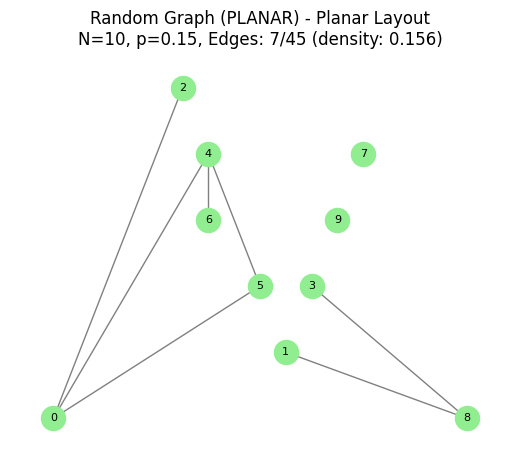

  ✓ Graph can be drawn without edge crossings!
Graph stats: N=10, edges=7, avg_degree=1.40, density=0.1556
Log rule: d = 4*log₂(10) ≈ 12
Epoch 0, Loss: 19.2511
Epoch 100, Loss: 7.3588
Epoch 200, Loss: 6.4591
Epoch 300, Loss: 6.3506
Epoch 400, Loss: 6.3297
Epoch 500, Loss: 6.3231
Epoch 600, Loss: 6.3200
Epoch 700, Loss: 6.3184
Epoch 800, Loss: 6.3174
Epoch 900, Loss: 6.3168
Epoch 1000, Loss: 6.3164
Epoch 1100, Loss: 6.3161
Epoch 1200, Loss: 6.3159
Epoch 1300, Loss: 6.3158
Epoch 1400, Loss: 6.3157
Epoch 1500, Loss: 6.3156
Epoch 1600, Loss: 6.3155
Epoch 1700, Loss: 6.3155
Epoch 1800, Loss: 6.3154
Epoch 1900, Loss: 6.3154

Testing reconstruction:
Nodes (0,0): True=0.0, Pred=0.821
Nodes (0,1): True=0.0, Pred=0.000
Nodes (0,2): True=1.0, Pred=0.458
Nodes (0,3): True=0.0, Pred=-0.000
Nodes (0,4): True=1.0, Pred=0.650
Nodes (0,5): True=1.0, Pred=0.639
Nodes (0,6): True=0.0, Pred=0.181
Nodes (0,7): True=0.0, Pred=-0.000
Nodes (0,8): True=0.0, Pred=-0.000
Nodes (0,9): True=0.0, Pred=0.000
Nodes 

In [26]:
# Parameters
N = 10  # Number of nodes
p = 0.15  # Edge probability

# Generate graph
G, adj_matrix, edge_index = generate_random_graph(N, p, seed=41)

# Visualize with planarity check
is_planar = visualize_graph(G, N, p)

# # Display adjacency matrix
# plt.figure(figsize=(8, 6))
# plt.imshow(adj_matrix, cmap='Blues', interpolation='nearest')
# plt.title(f'Adjacency Matrix (N={N}, p={p})')
# plt.colorbar()
# plt.show()

# # Print PyTorch tensors for ML use
# print(f"\nPyTorch tensors:")
# print(f"Adjacency matrix shape: {adj_matrix.shape}")
# print(f"Edge index shape: {edge_index.shape}")
# print(f"Edge index (first 10 edges):\n{edge_index[:, :10]}")

# Convert to PyTorch tensors
adj_tensor = torch.from_numpy(adj_matrix).float()
# print(f"Adjacency tensor shape: {adj_tensor.shape}")
    
A = adj_matrix
d = estimate_embedding_dim(A, method='log', verbose=True)

# Train embeddings
d = 64
model, losses = train_node_embeddings(A, embedding_dim=d, lr=0.001, epochs=2000)

# Get final embeddings
node_indices = torch.arange(N)
final_embeddings = model(node_indices)

# print(f"\nFinal embeddings shape: {final_embeddings.shape}")
# print("Final embeddings:")
# print(final_embeddings.detach().numpy())

# Test reconstruction
print("\nTesting reconstruction:")
with torch.no_grad():
    for i in range(N):
        for j in range(N):
            z_i = model(torch.tensor([i]))
            z_j = model(torch.tensor([j]))
            pred_sim = model.decode(z_i, z_j).item()
            true_sim = A[i, j]
            print(f"Nodes ({i},{j}): True={true_sim}, Pred={pred_sim:.3f}")



Try to understand the min dimension that makes the embeddings work. Must depend on node and edges. Do a good prompting for the experiment with tiny graphs. Make sure things work there. Watch the learning curves. See different learning rates and initializations.m